In [1]:
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import alen, arange
import math
from math import sqrt
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import AdaBoostRegressor
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor

from sklearn.svm import SVR
#### PLS
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from scipy.signal import savgol_filter
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy.signal import savgol_filter

In [5]:
#BPSO

def pls_optimise_components(X, y, npc):
 
    rmsecv = np.zeros(npc)
    for i in range(1,npc+1,1):
 
        # Simple PLS
        pls_simple = PLSRegression(n_components=i)
        # Fit
        pls_simple.fit(X, y)
        #cv = LeaveOneOut()
        cv=10
        # Cross-validation
        y_cv = cross_val_predict(pls_simple, X, y, cv=cv)
 
        # Calculate scores
        score = r2_score(y, y_cv)
        rmsecv[i-1] = np.sqrt(mean_squared_error(y, y_cv))
 
    # Find the minimum of ther RMSE and its location
    opt_comp, rmsecv_min = np.argmin(rmsecv),  rmsecv[np.argmin(rmsecv)]
 
    return (opt_comp+1, rmsecv_min)

def base_pls(X,y,n_components, return_model=False):
 
    # Simple PLS
    pls_simple = PLSRegression(n_components=n_components)
    # Fit
    pls_simple.fit(X, y)
    #cv = 10
    cv= 10
    # Cross-validation
    y_cv = cross_val_predict(pls_simple, X, y, cv=cv)
 
    # Calculate scores
    score = r2_score(y, y_cv)
    rmsecv = np.sqrt(mean_squared_error(y, y_cv))
 
    if return_model == False:
        return(y_cv, score, rmsecv)
    else:
        return(y_cv, score, rmsecv, pls_simple)
    
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
# Create an instance 
#reg = linear_model.LinearRegression

# Define objective function
def f_per_particle(m, alpha):
    """Computes for the objective function per particle

    Inputs
    ------
    m : numpy.ndarray
        Binary mask that can be obtained from BinaryPSO, will
        be used to mask features.
    alpha: float (default is 0.5)
        Constant weight for trading-off classifier performance
        and number of features

    Returns
    -------
    numpy.ndarray
        Computed objective function
    """
    
    total_features = dimensions
    # Get the subset of the features from the binary mask

    #X_sav = savgol_filter(X_train, 3, polyorder=2, deriv=1)

    if np.count_nonzero(m) == 0:
        X_subset = X_train
    else:
        X_subset = X_train[:,m==1]

    
 

    # #regr = make_pipeline(StandardScaler(), SVR())
    # #regr = make_pipeline(StandardScaler(), RandomForestRegressor(max_depth=5, random_state=1))
    # #regr = make_pipeline(StandardScaler(), SVR(C = 0.5, degree= 1, kernel= 'rbf',epsilon= 0.16))
    # #X1 = savgol_filter(X_subset, 3, polyorder=2, deriv=1)
    # reg1 = GradientBoostingRegressor(random_state=1)
    # reg2 = RandomForestRegressor(random_state=1)
    # reg3 = LinearRegression()
    # ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
    # ereg = ereg.fit(X_subset, y_train_oleo)
    # #regr.fit(X_subset, y_train_oleo)
    # #y_pred = cross_val_predict(regr, X_subset, y_train_oleo, cv=10)
    # y_pred = ereg.predict(X_subset)
    # #y_pred = regr.predict(X1)
    # r2cv = mean_squared_error(y_train_oleo, y_pred)
    # #r2cv = r2_score(y_train_oleo, y_pred)
    # P = r2cv
    # #P = (classifier.predict(X_subset) == y).mean()
    # # Compute for the objective function
    # j = (alpha * (1.0 - (1-P))
    #     + (1.0 - alpha) * (1 - (X_subset.shape[1] / total_features)))



    opt_comp, rmsecv_min = pls_optimise_components(X_subset, y_train_oleo, 8)
    predicted, r2cv, rmscv = base_pls(X_subset, y_train_oleo, opt_comp)
    
    P = r2cv
    #P = (classifier.predict(X_subset) == y).mean()
    # Compute for the objective function
    j = (alpha * (1.0 - P)
        + (1.0 - alpha) * (1 - (X_subset.shape[1] / total_features)))

    return j

def f(x, alpha=0.88):
    """Higher-level method to do classification in the
    whole swarm.

    Inputs
    ------
    x: numpy.ndarray of shape (n_particles, dimensions)
        The swarm that will perform the search

    Returns
    -------
    numpy.ndarray of shape (n_particles, )
        The computed loss for each particle
    """
    n_particles = x.shape[0]
    j = [f_per_particle(x[i], alpha) for i in range(n_particles)]
    return np.array(j)

def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
 
        # Apply correction
        output_data[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
 
    return output_data

def msc(input_data):
     # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
 
    # Get the reference spectrum. If not given, estimate it from the mean    

    # Calculate mean
    ref = np.mean(input_data, axis=0)

 
    # Define a new array and populate it with the corrected data    
    output_data= np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        output_data[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 
    return output_data

In [6]:
df = pd.read_excel(open('Data/Spectra datasets NIRS_intact_mangos.xlsx', 'rb'),
              sheet_name='Raw Spectra data') 
df2 = pd.read_excel(open('Data/Spectra datasets NIRS_intact_mangos.xlsx', 'rb'),
              sheet_name='TA and Vit C') 
df2 = df2.iloc[:,:3]
df = pd.merge(df, df2, left_index=True, right_index=True)

In [7]:

df.drop(columns=['No'], inplace=True)
df.head()

,No.,variety,999.9,1000.3,1000.7,1001.1,1001.4,1001.8,1002.2,1002.6,...,2483.5,2485.8,2488.2,2490.6,2493,2495.4,2497.8,2500.2,TA (mg/100gr FM),Vit C (mg/100gr FM)
0,1,Kent,0.428519,0.427882,0.427481,0.427315,0.427002,0.426289,0.425939,0.425540,...,1.585399,1.586905,1.587933,1.589149,1.590033,1.591012,1.591306,1.591581,268.56,29.95
1,2,Kent,0.455501,0.454918,0.454001,0.453701,0.453563,0.453152,0.452960,0.452852,...,1.455168,1.455935,1.456416,1.457003,1.457670,1.458605,1.459040,1.459716,291.07,31.36
2,3,Kent,0.429935,0.429312,0.429004,0.428822,0.428090,0.427227,0.427130,0.427362,...,1.509284,1.510514,1.511341,1.512626,1.513753,1.514989,1.515703,1.515965,378.17,33.07
3,4,Kent,0.417054,0.416565,0.416097,0.415913,0.415398,0.414692,0.414409,0.413956,...,1.583658,1.585719,1.586842,1.587910,1.588926,1.589898,1.590328,1.591335,276.55,30.63
4,5,Kent,0.433239,0.432622,0.432626,0.432379,0.431620,0.430710,0.430836,0.430847,...,1.604524,1.605982,1.606778,1.607837,1.608756,1.609967,1.610900,1.611099,324.40,31.69


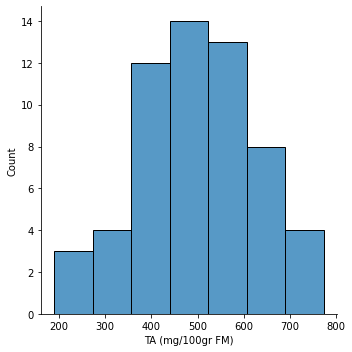

In [8]:
import seaborn as sns
sns.displot(df['TA (mg/100gr FM)'])

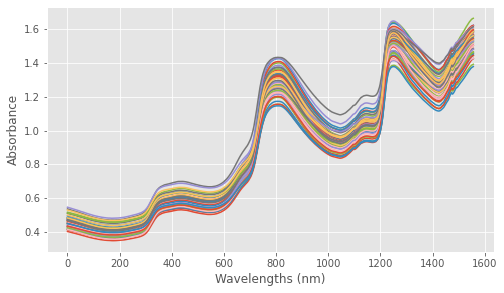

In [9]:
wl = np.arange(0, 1557, 1)
plt.figure(figsize=(8, 4.5))
with plt.style.context('ggplot'):
    plt.plot(wl, df.iloc[:,2:-2].values.T)
    plt.xlabel("Wavelengths (nm)")
    plt.ylabel("Absorbance")
    plt.show()

In [10]:
df.describe()

,No.,999.9,1000.3,1000.7,1001.1,1001.4,1001.8,1002.2,1002.6,1003,...,2483.5,2485.8,2488.2,2490.6,2493,2495.4,2497.8,2500.2,TA (mg/100gr FM),Vit C (mg/100gr FM)
count,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,...,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000
mean,29.500000,0.460653,0.459933,0.459574,0.459491,0.459061,0.458285,0.457949,0.457766,0.457380,...,1.526632,1.528022,1.528898,1.529857,1.530579,1.531431,1.532195,1.533000,495.481552,32.206207
std,16.886879,0.031786,0.031751,0.031767,0.031751,0.031688,0.031685,0.031679,0.031711,0.031670,...,0.066033,0.066071,0.066045,0.066049,0.066061,0.066029,0.066026,0.065970,131.071278,1.306183
min,1.000000,0.402086,0.401481,0.401110,0.401233,0.401014,0.400085,0.399549,0.399255,0.398900,...,1.372218,1.373669,1.374740,1.375916,1.376677,1.377766,1.378839,1.379707,189.720000,28.930000
25%,15.250000,0.435018,0.434316,0.433993,0.433932,0.433669,0.432855,0.432442,0.432238,0.432158,...,1.475048,1.476691,1.477722,1.478711,1.479259,1.480368,1.481292,1.482093,413.210000,31.585000
50%,29.500000,0.461451,0.460869,0.460091,0.459754,0.459469,0.458879,0.458529,0.458229,0.457678,...,1.539385,1.540158,1.541077,1.542174,1.542736,1.543302,1.544208,1.545211,490.810000,32.125000
75%,43.750000,0.477194,0.476610,0.476370,0.476418,0.475867,0.475082,0.474711,0.474384,0.473837,...,1.577103,1.579154,1.580488,1.581241,1.581983,1.583017,1.583784,1.584993,582.930000,32.742500
max,58.000000,0.545846,0.544815,0.544524,0.544631,0.544169,0.543143,0.542535,0.542080,0.541842,...,1.658891,1.660840,1.661063,1.662344,1.663918,1.664709,1.664998,1.665684,772.770000,35.660000


In [86]:
##df.iloc[:,2:-2] = snv(df.values[:,2:-2])
df.iloc[:,2:-2] = savgol_filter(df.values[:,2:-2], 15, polyorder=2, deriv=1)
#df.iloc[:,1:-2] = snv(df.values[:,1:-2])
df_pretreat = df.iloc[:, 2:-2]
df_pretreat['TA'] = df['TA (mg/100gr FM)']
df_pretreat['C'] = df['Vit C (mg/100gr FM)']
df_pretreat['class'] = (df_pretreat['TA']/100).astype(int)

for index, row in df_pretreat.iterrows():
    if row['class']== 1:
        df_pretreat.loc[index, 'class'] = 2

df_pretreat

,999.9,1000.3,1000.7,1001.1,1001.4,1001.8,1002.2,1002.6,1003,1003.4,...,2485.8,2488.2,2490.6,2493,2495.4,2497.8,2500.2,TA,C,class
0,-0.000408,-0.000411,-0.000414,-0.000416,-0.000419,-0.000422,-0.000424,-0.000427,-0.000434,-0.000433,...,0.001153,0.001058,0.000963,0.000868,0.000773,0.000678,0.000583,268.56,29.95,2
1,-0.000276,-0.000295,-0.000314,-0.000332,-0.000351,-0.000370,-0.000389,-0.000408,-0.000416,-0.000417,...,0.000845,0.000763,0.000682,0.000601,0.000520,0.000438,0.000357,291.07,31.36,2
2,-0.000331,-0.000340,-0.000350,-0.000359,-0.000369,-0.000378,-0.000388,-0.000398,-0.000394,-0.000399,...,0.001277,0.001171,0.001065,0.000960,0.000854,0.000748,0.000643,378.17,33.07,3
3,-0.000463,-0.000455,-0.000447,-0.000439,-0.000431,-0.000423,-0.000415,-0.000407,-0.000403,-0.000406,...,0.001354,0.001220,0.001085,0.000950,0.000816,0.000681,0.000546,276.55,30.63,2
4,-0.000342,-0.000353,-0.000365,-0.000376,-0.000388,-0.000399,-0.000411,-0.000422,-0.000432,-0.000443,...,0.001285,0.001168,0.001051,0.000933,0.000816,0.000699,0.000582,324.40,31.69,3
5,-0.000423,-0.000423,-0.000423,-0.000423,-0.000423,-0.000422,-0.000422,-0.000422,-0.000425,-0.000433,...,0.001296,0.001174,0.001053,0.000931,0.000810,0.000688,0.000567,394.76,32.02,3
6,-0.000369,-0.000383,-0.000397,-0.000411,-0.000425,-0.000439,-0.000453,-0.000467,-0.000469,-0.000472,...,0.000905,0.000819,0.000733,0.000648,0.000562,0.000476,0.000390,449.97,32.43,4
7,-0.000346,-0.000353,-0.000359,-0.000366,-0.000372,-0.000379,-0.000385,-0.000392,-0.000398,-0.000414,...,0.001169,0.001091,0.001014,0.000936,0.000858,0.000781,0.000703,189.72,28.93,2
8,-0.000516,-0.000507,-0.000499,-0.000490,-0.000481,-0.000472,-0.000463,-0.000455,-0.000445,-0.000437,...,0.000998,0.000923,0.000847,0.000771,0.000695,0.000619,0.000543,298.37,29.94,2
9,-0.000512,-0.000498,-0.000484,-0.000470,-0.000456,-0.000442,-0.000428,-0.000414,-0.000415,-0.000414,...,0.001303,0.001215,0.001126,0.001038,0.000950,0.000862,0.000774,203.86,29.18,2


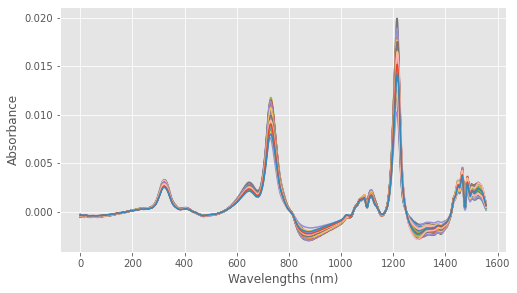

In [87]:
wl = np.arange(0, 1557, 1)
plt.figure(figsize=(8, 4.5))
with plt.style.context('ggplot'):
    plt.plot(wl, df_pretreat.iloc[:,:-3].values.T)
    plt.xlabel("Wavelengths (nm)")
    plt.ylabel("Absorbance")
    plt.show()

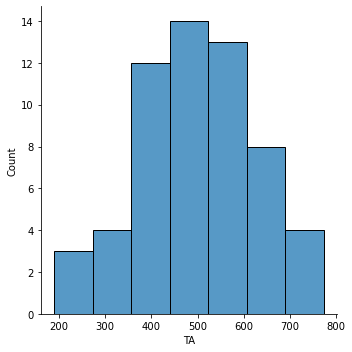

In [88]:
import seaborn as sns
sns.displot(df_pretreat['TA'])

In [89]:
df_pretreat.describe()

,999.9,1000.3,1000.7,1001.1,1001.4,1001.8,1002.2,1002.6,1003,1003.4,...,2485.8,2488.2,2490.6,2493,2495.4,2497.8,2500.2,TA,C,class
count,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,...,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000
mean,-0.000389,-0.000391,-0.000394,-0.000396,-0.000398,-0.000400,-0.000402,-0.000404,-0.000407,-0.000413,...,0.001131,0.001038,0.000946,0.000854,0.000761,0.000669,0.000577,495.481552,32.206207,4.431034
std,0.000070,0.000063,0.000055,0.000048,0.000042,0.000036,0.000032,0.000030,0.000030,0.000029,...,0.000246,0.000229,0.000213,0.000198,0.000185,0.000173,0.000162,131.071278,1.306183,1.326016
min,-0.000545,-0.000529,-0.000514,-0.000501,-0.000491,-0.000488,-0.000486,-0.000485,-0.000486,-0.000484,...,0.000608,0.000541,0.000474,0.000407,0.000340,0.000273,0.000206,189.720000,28.930000,2.000000
25%,-0.000429,-0.000428,-0.000427,-0.000423,-0.000425,-0.000424,-0.000426,-0.000426,-0.000426,-0.000433,...,0.000941,0.000875,0.000810,0.000740,0.000665,0.000565,0.000477,413.210000,31.585000,4.000000
50%,-0.000383,-0.000386,-0.000390,-0.000392,-0.000394,-0.000393,-0.000394,-0.000400,-0.000402,-0.000413,...,0.001152,0.001058,0.000957,0.000863,0.000770,0.000677,0.000581,490.810000,32.125000,4.000000
75%,-0.000337,-0.000346,-0.000355,-0.000361,-0.000365,-0.000371,-0.000384,-0.000381,-0.000386,-0.000397,...,0.001298,0.001203,0.001089,0.000985,0.000876,0.000778,0.000691,582.930000,32.742500,5.000000
max,-0.000239,-0.000259,-0.000279,-0.000299,-0.000318,-0.000330,-0.000333,-0.000336,-0.000334,-0.000335,...,0.001651,0.001517,0.001398,0.001290,0.001183,0.001075,0.000968,772.770000,35.660000,7.000000


In [90]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



pca = PCA(n_components=5)
T = pca.fit_transform(df_pretreat.iloc[:,:-3].values)
df_pca = pd.DataFrame(T)
df_pca.rename(columns={0: 'PC1', 1: 'PC2', 2: 'PC3', 3: 'PC4', 4: 'PC5'}, inplace=True)

print(pca.explained_variance_ratio_)

from sklearn.cluster import DBSCAN
data = list(zip(T[:, 0], T[:, 1]))
clustering = DBSCAN(eps=0.004, min_samples=2).fit(data)
df_pca['cluster'] = clustering.labels_
#df1['cluster'] = clustering.labels_


# df1_cluster1 = df1[df1['cluster']==1]
# dataset= df1_cluster1
# dataset.drop(columns=['cluster'], inplace=True)
# dataset.head()

[0.63017627 0.32966489 0.01968379 0.00705665 0.00398959]


In [176]:
#df_pca['PC1'] = df_pca['PC1']*-1
df_pca['PC2'] = df_pca['PC2']
df_pca['ID'] = df.index
df_pca

,PC1,PC2,PC3,PC4,PC5,cluster,ID
0,-0.015066,0.005363,-0.001018,-0.001057,0.001343,0,0
1,0.006786,0.005566,-0.001659,-0.001627,0.000631,1,1
2,-0.004939,-0.001572,-0.000228,-0.001675,0.000557,1,2
3,-0.020953,-0.000998,-0.002123,-0.001670,0.000722,0,3
4,-0.016160,0.003106,-0.000347,-0.000271,0.000837,0,4
5,-0.015404,0.007497,0.000744,0.000145,0.000459,0,5
6,-0.000803,0.007408,0.000827,0.000301,0.000444,1,6
7,-0.012349,0.006996,-0.000325,-0.000781,0.000001,0,7
8,-0.005373,0.009274,0.002588,-0.000582,0.000268,2,8
9,-0.017854,0.000029,0.000952,-0.001402,-0.000036,0,9


In [177]:
import plotly.express as px

fig = px.scatter(df_pca, x='PC1', y='PC2', render_mode='svg', hover_data=['ID'],color='cluster')

fig.show()

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [1557] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [2] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [1557] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]
[pca] >Plot PC1 vs PC2 with loadings.


(<Figure size 1080x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Outliers marked using Hotellings T2 method.'}, xlabel='PC1 (83.2% expl.var)', ylabel='PC2 (14.5% expl.var)'>)

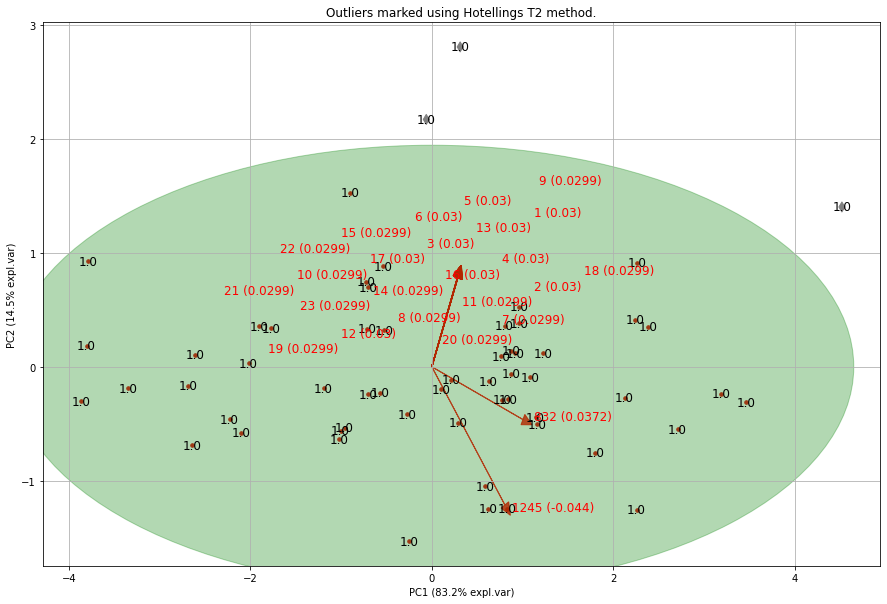

In [36]:
# import numpy as np
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
from pca import pca

pca_model = pca(detect_outliers=['ht2', 'spe'],n_std=2.5 )

results = pca_model.fit_transform(X)
#PCA(n_components=5)
# Plot Hotellings T2
pca_model.biplot(SPE=True, hotellingt2=True, title='Outliers marked using Hotellings T2 method.', legend=False)

In [ ]:
# df_pretreat = df.iloc[:, 1:-2]
# df_pretreat['Umidade'] = df['Moisture Content (%)']
# df_pretreat['Oleo'] = df['Fat Content (%)']

In [62]:
###Remove maybe 39 and 42
df_pretreat.drop([44,46], inplace=True)

In [385]:
df_pretreat['class'] = 0
for index, row in df_pretreat.iterrows():
    if row['TA'] < 300:
        df_pretreat.loc[index, 'class'] = 0
    elif row['TA'] < 400:
        df_pretreat.loc[index, 'class'] = 1
    elif row['TA'] < 500:
        df_pretreat.loc[index, 'class'] = 2
    elif row['TA'] < 600:
        df_pretreat.loc[index, 'class'] = 3
    elif row['TA'] < 700:
        df_pretreat.loc[index, 'class'] = 3
    else:
        df_pretreat.loc[index, 'class'] = 4

In [126]:
df_pretreat['class'] = clustering.labels_
df_pretreat.head()

,999.9,1000.3,1000.7,1001.1,1001.4,1001.8,1002.2,1002.6,1003,1003.4,...,2485.8,2488.2,2490.6,2493,2495.4,2497.8,2500.2,TA,C,class
0,-0.000408,-0.000411,-0.000414,-0.000416,-0.000419,-0.000422,-0.000424,-0.000427,-0.000434,-0.000433,...,0.001153,0.001058,0.000963,0.000868,0.000773,0.000678,0.000583,268.56,29.95,0
1,-0.000276,-0.000295,-0.000314,-0.000332,-0.000351,-0.000370,-0.000389,-0.000408,-0.000416,-0.000417,...,0.000845,0.000763,0.000682,0.000601,0.000520,0.000438,0.000357,291.07,31.36,1
2,-0.000331,-0.000340,-0.000350,-0.000359,-0.000369,-0.000378,-0.000388,-0.000398,-0.000394,-0.000399,...,0.001277,0.001171,0.001065,0.000960,0.000854,0.000748,0.000643,378.17,33.07,1
3,-0.000463,-0.000455,-0.000447,-0.000439,-0.000431,-0.000423,-0.000415,-0.000407,-0.000403,-0.000406,...,0.001354,0.001220,0.001085,0.000950,0.000816,0.000681,0.000546,276.55,30.63,0
4,-0.000342,-0.000353,-0.000365,-0.000376,-0.000388,-0.000399,-0.000411,-0.000422,-0.000432,-0.000443,...,0.001285,0.001168,0.001051,0.000933,0.000816,0.000699,0.000582,324.40,31.69,0


In [189]:
##Sans modif

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


y = df_pretreat[['TA','C','class']]
## Do not take the reference value and the class
X = df_pretreat.values[:, :-3]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0,stratify=y['class'])


# col = [0,2,3,6,7,8,16,21,27,29,31,32,33,39,40,46,51,53,54,56,58,59,62,63,64,65,66,67,70,71,73,85,92,94,96,97,99,102,107,110,113,119,122,125,130,131,132,133,134,137,139,141,143,146,147,148,150,154,155,157,158,159,166,167,168,170,178,179,182,187,190,192,193,195,196,199,201,202,203,205,206,208,209,210,211,214,215,217,219,221,222,224,226,227,228,229,232,235,236,237,242,245,246,254,255,266,267,270,274,279,280,284,286,288,290,294,295,297,298,300,301,302,304,305,307,309,310,312,318,319,321,323,324,325,327,328,331,332,334,337,338,351,353,354,355,356,357,362,367,368,369,370,372,374,375,377,379,381,386,387,391,392,399,401,402,411,412,413,414,422,425,426,428,429,430,431,435,437,439,440,441,443,444,445,446,448,457,461,462,464,465,467,470,472,474,479,481,482,483,485,486,490,494,495,498,500,503,506,507,508,511,512,513,515,518,519,520,524,532,536,537,539,544,547,549,551,555,560,565,567,570,571,572,573,575,578,580,581,585,587,589,592,598,599,605,610,612,615,618,622,630,633,636,637,640,642,649,652,653,656,666,667,668,673,674,675,677,688,689,690,691,692,695,696,699,700,701,702,703,707,708,709,711,712,713,714,717,719,722,724,725,726,727,728,729,730,732,734,735,741,744,746,747,748,752,756,758,759,760,763,766,768,769,770,772,774,775,776,783,788,789,791,792,793,794,797,801,802,806,807,810,812,813,814,818,822,826,833,834,837,839,841,843,844,845,850,855,862,863,864,869,872,873,874,875,876,879,887,889,900,901,903,904,907,908,909,912,916,920,922,923,925,926,928,929,931,932,940,942,943,945,947,948,951,955,957,964,966,967,969,971,973,974,977,978,982,989,994,1000,1001,1002,1003,1005,1007,1008,1009,1013,1014,1026,1028,1029,1031,1033,1034,1035,1040,1041,1044,1045,1047,1051,1053,1059,1062,1063,1065,1067,1073,1075,1077,1079,1083,1084,1091,1093,1094,1096,1102,1104,1105,1110,1113,1114,1117,1118,1121,1122,1126,1127,1130,1137,1139,1141,1145,1147,1148,1153,1158,1159,1161,1164,1166,1167,1168,1171,1175,1176,1178,1180,1185,1188,1189,1196,1198,1200,1202,1203,1204,1210,1211,1213,1215,1216,1220,1230,1234,1237,1238,1239,1242,1249,1253,1255,1256,1257,1260,1262,1263,1264,1265,1267,1269,1270,1271,1272,1276,1277,1278,1284,1292,1293,1297,1306,1307,1312,1314,1315,1318,1329,1331,1332,1335,1345,1346,1347,1351,1352,1353,1354,1355,1356,1357,1358,1359,1362,1364,1365,1366,1369,1372,1376,1378,1381,1385,1386,1388,1391,1394,1397,1399,1401,1402,1406,1407,1410,1412,1413,1414,1415,1417,1419,1427,1428,1431,1432,1434,1435,1439,1440,1448,1449,1453,1456,1458,1461,1463,1465,1466,1482,1486,1493,1495,1497,1498,1507,1508,1511,1514,1515,1517,1525,1527,1528,1534,1535,1541,1542,1543,1546,1547,1553,1554]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))
# X = (np.delete(X, col,1))
# col = [ 0,   2,   3,   9,  10,  11,  13,  14,  20,  22,  27,  32,  33,
#         34,  35,  39,  44,  48,  56,  57,  59,  60,  62,  67,  71,  76,
#         77,  78,  82,  88,  92,  93,  94,  96, 100, 102, 103, 104, 106,
#        108, 113, 114, 116, 119, 121, 126, 128, 134, 136, 140, 148, 152,
#        154, 156, 158, 161, 162, 164, 165, 166, 168, 173, 182, 183, 184,
#        185, 193, 203, 206, 208, 210, 212, 213, 219, 224, 227, 230, 231,
#        233, 234, 237, 238, 242, 243, 244, 246, 247, 248, 250, 251, 256,
#        259, 263, 265, 267, 271, 272, 276, 277, 281, 282, 293, 294, 303,
#        308, 311, 312, 314, 317, 327, 331, 332, 333, 338, 340, 343, 344,
#        350, 351, 355, 359, 360, 361, 362, 367, 375, 381, 382, 385, 389,
#        390, 393, 394, 395, 396, 397, 398, 399, 401, 406, 407, 411, 412,
#        414, 415, 418, 420, 422, 424, 426, 429, 430, 432, 433, 436, 437,
#        438, 440, 446, 448, 449, 451, 455, 458, 465, 466, 471, 472, 473,
#        479, 482, 485, 487, 490, 491, 492, 493, 499, 500, 501, 504, 505,
#        506, 509, 511, 517, 520, 521, 522, 526, 527, 531, 532, 535, 536,
#        539, 540, 541, 543, 548, 552, 561, 566, 570, 571, 573, 575, 578,
#        583, 598, 599, 604, 605, 608, 616, 618, 620, 623, 624, 626, 628,
#        629, 631, 632, 635, 637, 639, 641, 642, 644, 645, 646, 647, 648,
#        650, 651, 656, 660, 664, 667, 668, 669, 670, 674, 676, 678, 681,
#        684, 686, 688, 690, 691, 692, 696, 699, 700, 705, 710, 712, 714,
#        715, 719, 731, 732, 733, 738, 744, 747, 749, 751, 757, 759, 760,
#        761, 766, 768, 772, 773, 775, 777, 779, 782, 784, 785, 786, 788,
#        789, 790, 791, 793, 796, 799, 801, 811, 812, 813, 814, 817, 822,
#        825, 831, 833, 834, 837, 838, 839, 841, 845, 850, 855, 858, 860,
#        869, 870, 877, 882, 884, 885, 887, 894, 896, 898, 904, 908, 910,
#        911, 913, 914, 915, 916, 918, 925, 927, 932, 937, 938, 939, 942,
#        944, 946, 949, 950, 951, 953]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))
# X = (np.delete(X, col,1))


# col = [2,   3,   6,   7,   9,  10,  12,  13,  14,  15,  17,  19,  24,
#         34,  35,  41,  43,  44,  45,  46,  48,  52,  55,  56,  60,  63,
#         64,  66,  67,  68,  70,  72,  76,  79,  81,  82,  83,  85,  88,
#         89,  91,  93, 103, 104, 107, 108, 111, 113, 114, 117, 119, 122,
#        125, 127, 129, 131, 133, 135, 141, 142, 143, 149, 152, 156, 158,
#        162, 164, 172, 174, 175, 178, 180, 185, 187, 190, 191, 192, 202,
#        203, 208, 211, 213, 215, 217, 218, 223, 231, 232, 233, 234, 235,
#        236, 238, 239, 242, 243, 246, 250, 252, 253, 254, 259, 262, 265,
#        267, 268, 271, 273, 278, 279, 280, 285, 291, 298, 299, 302, 303,
#        310, 314, 315, 317, 320, 327, 328, 330, 331, 333, 334, 337, 339,
#        344, 346, 347, 350, 353, 354, 360, 364, 365, 366, 368, 370, 371,
#        372, 374, 375, 376, 377, 378, 385, 386, 388, 392, 394, 396, 399,
#        401, 403, 408, 412, 417, 421, 424, 426, 427, 429, 431, 432, 436,
#        439, 440, 441, 442, 444, 445]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))
# X = (np.delete(X, col,1))

# # X_train_snv = msc(X_train)
# # X_#test_snv = msc(X_test)

y_train_oleo = y_train['TA']


y_test_oleo = y_test['TA']

#X1 = savgol_filter(X_train, 23, polyorder=2, deriv=2)
#X2 = savgol_filter(X_test, 23, polyorder=2, deriv=2)

# X_train_snv = msc(X_train)
# X_test_snv = msc(X_test)

# mean centre correction
#X_mc = mc(X1)

##Standard Normal Variate

# Xsnv = snv(X_train)

In [15]:
##Derive 15

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


y = df_pretreat[['TA','C','class']]
## Do not take the reference value and the class
X = df_pretreat.values[:, :-3]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0,stratify=y['class'])

col = [0,1,2,3,4,5,6,7,8,11,12,15,16,17,18,19,22,24,31,32,33,36,38,39,42,43,44,46,47,48,49,50,55,64,65,66,67,69,73,74,75,76,77,79,81,82,83,84,85,86,89,92,93,95,96,98,108,109,110,111,112,113,115,116,117,118,122,124,125,133,134,135,136,140,141,143,144,145,149,150,152,153,154,155,156,157,158,159,160,163,164,165,166,172,174,175,176,178,179,180,181,182,183,184,185,187,188,195,196,197,200,201,202,203,211,214,216,222,225,227,231,233,237,238,239,240,241,242,243,252,257,258,260,261,262,263,264,267,268,271,273,277,280,282,284,285,286,287,289,295,297,299,300,301,302,303,310,315,317,321,324,326,327,329,332,334,335,336,340,341,342,349,350,352,353,358,360,363,365,367,369,370,372,374,377,378,379,380,387,390,391,393,395,396,399,401,403,409,411,420,421,422,423,424,425,426,427,431,432,435,436,439,442,447,448,449,450,452,454,455,458,461,462,463,464,466,472,473,477,478,479,480,482,484,487,490,493,495,496,498,500,505,506,509,510,511,512,514,515,516,518,519,520,521,522,523,526,532,533,535,536,539,541,542,543,544,545,549,550,551,558,559,560,561,563,565,568,569,570,571,572,573,575,581,582,585,590,597,598,600,601,603,605,618,619,620,621,627,629,630,631,636,641,643,644,647,649,652,653,654,655,656,660,664,665,666,667,669,673,674,680,681,682,688,689,690,693,694,697,703,704,705,708,709,710,711,723,725,727,729,733,736,737,739,741,742,747,748,751,753,756,758,760,763,764,771,773,775,776,778,779,780,781,784,788,789,795,798,799,800,802,804,808,809,810,811,812,813,816,819,820,824,826,832,842,846,852,854,856,859,860,863,864,868,871,878,881,884,885,887,894,902,910,913,916,919,924,929,930,931,937,939,940,946,947,950,953,955,958,959,960,962,965,966,970,972,978,979,983,984,987,990,993,995,997,998,1001,1004,1006,1013,1019,1025,1030,1031,1032,1033,1035,1038,1039,1047,1048,1049,1052,1053,1054,1056,1059,1060,1062,1063,1064,1072,1073,1074,1075,1076,1078,1079,1080,1081,1082,1083,1085,1086,1087,1090,1093,1094,1096,1097,1098,1099,1101,1104,1105,1106,1108,1109,1110,1111,1113,1114,1116,1121,1123,1125,1130,1131,1135,1140,1141,1147,1148,1157,1158,1162,1163,1165,1169,1171,1172,1173,1176,1177,1178,1181,1184,1185,1187,1188,1190,1191,1195,1196,1200,1201,1205,1206,1208,1209,1213,1217,1223,1224,1226,1228,1230,1232,1236,1237,1238,1240,1242,1252,1253,1255,1257,1265,1266,1268,1269,1270,1272,1275,1277,1278,1281,1284,1289,1294,1298,1299,1300,1301,1305,1313,1315,1320,1324,1327,1330,1331,1333,1336,1341,1347,1348,1349,1351,1353,1356,1359,1363,1366,1367,1368,1371,1374,1377,1380,1385,1386,1390,1392,1395,1396,1397,1398,1399,1400,1401,1402,1406,1407,1408,1409,1410,1412,1414,1415,1417,1418,1419,1420,1422,1425,1429,1431,1432,1447,1456,1458,1461,1463,1466,1470,1475,1476,1479,1483,1484,1486,1487,1493,1494,1495,1499,1501,1507,1529,1530,1535,1536,1538,1544,1556]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))
X = (np.delete(X, col,1))

col = [ 3,7,8,9,13,15,16,18,23,24,25,27,29,33,34,37,38,41,48,50,53,55,56,57,62,63,66,67,69,70,73,75,76,78,79,81,82,84,85,86,87,88,90,95,97,98,100,101,103,106,107,109,110,111,117,119,122,124,125,130,134,135,138,140,141,142,143,145,150,151,153,157,159,161,163,165,167,169,170,171,176,180,181,184,185,187,188,190,191,194,195,197,199,200,204,206,211,215,216,220,221,223,224,225,226,228,230,233,234,235,237,241,242,243,245,247,249,255,258,259,262,264,265,272,273,274,276,277,278,279,281,282,285,288,292,293,294,295,297,300,301,304,305,306,307,308,311,312,315,316,317,321,323,330,332,333,334,335,338,340,341,343,344,346,347,348,349,351,352,359,361,363,364,367,369,370,371,372,375,380,382,383,389,390,392,393,394,396,399,400,404,405,408,411,413,415,418,420,422,423,424,427,428,430,431,432,434,436,437,439,440,441,442,445,447,448,450,451,454,457,458,465,468,473,477,480,481,484,490,491,492,494,500,501,502,510,515,516,517,518,520,524,525,526,528,532,537,538,540,541,545,548,549,550,554,555,559,560,564,565,566,569,573,574,575,576,579,581,583,584,589,591,592,594,595,602,603,606,607,611,614,616,619,620,627,629,633,634,636,639,640,642,644,645,647,648,655,658,660,661,665,667,668,673,674,675,685,687,697,699,701,706,707,709,710,713,716,723,725,730,732,734,735,737,742,743,744,745,747,749,750,752,755,758,759,760,765,766,767,770,771,772,773,777,783,785,786,788,790,791,793,795,797,799,801,803,805,806,808,812,813,814,815,820,821,824,828,830,833,835,842,844,846,850,851,853,856,862,864,865,866,868,872,880,882,885,889,892,893,897,898,900,903,906,910]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))
X = (np.delete(X, col,1))


col = [0,   1,   2,   3,   4,   5,   6,   9,  10,  13,  16,  18,  20,
        25,  28,  29,  30,  32,  33,  34,  35,  38,  39,  40,  42,  43,
        46,  52,  53,  55,  57,  58,  59,  60,  62,  64,  65,  66,  67,
        68,  70,  73,  78,  79,  82,  83,  85,  88,  91,  95,  97,  98,
       101, 103, 106, 112, 116, 119, 121, 124, 129, 133, 135, 146, 148,
       149, 151, 152, 153, 156, 157, 159, 170, 171, 172, 173, 175, 176,
       180, 181, 182, 186, 190, 193, 194, 195, 199, 200, 201, 203, 205,
       210, 215, 217, 219, 221, 222, 223, 226, 227, 228, 230, 235, 239,
       240, 241, 244, 245, 250, 257, 258, 259, 268, 270, 272, 273, 278,
       279, 282, 283, 286, 288, 291, 293, 298, 300, 301, 305, 306, 310,
       313, 314, 324, 325, 328, 331, 332, 334, 335, 336, 338, 340, 341,
       342, 343, 345, 346, 349, 350, 351, 354, 355, 357, 358, 362, 363,
       364, 369, 373, 374, 375, 381, 384, 385, 388, 389, 390, 392, 395,
       397, 398, 402, 404, 407, 410, 412, 414, 416, 419, 421, 423, 426,
       428, 429, 431, 433, 435, 437, 438, 439, 441, 448, 449, 450, 451,
       452, 453, 455, 456, 460, 465, 466, 467, 470, 477, 479, 481, 482,
       483, 484, 485, 486, 487, 490, 492, 497, 505, 507, 509, 510, 514]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))
X = (np.delete(X, col,1))

# col = [0,   3,   6,  11,  15,  16,  21,  24,  25,  27,  30,  32,  35,
#         39,  40,  42,  43,  44,  49,  55,  57,  58,  59,  60,  63,  64,
#         66,  68,  71,  72,  73,  77,  78,  82,  83,  87,  89,  91,  93,
#         95,  98, 103, 104, 108, 111, 120, 121, 122, 124, 126, 127, 129,
#        131, 134, 137, 139, 145, 151, 153, 154, 156, 157, 158, 165, 166,
#        171, 172, 176, 177, 182, 184, 185, 186, 188, 189, 196, 198, 200,
#        204, 205, 209, 211, 213, 217, 219, 226, 227, 237, 238, 242, 243,
#        245, 250, 251, 253, 254, 255, 259, 260, 263, 269, 272, 273, 281,
#        292]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))
# X = (np.delete(X, col,1))

# col = [ 4,   7,   9,  20,  22,  24,  26,  27,  29,  30,  33,  46,  47,
#         53,  56,  57,  63,  65,  70,  73,  76,  77,  79,  80,  83,  84,
#         88,  96,  98, 101, 103, 105, 110, 114, 117, 118, 121, 122, 123,
#        124, 132, 134, 136, 145, 146, 148, 151, 152, 154, 157, 160, 171,
#        175, 179, 182]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))
# X = (np.delete(X, col,1))

# col = [ 2,  13,  19,  20,  22,  26,  43,  49,  52,  54,  55,  61,  62,
#         64,  72,  73,  74,  77,  88,  89,  90,  98, 106, 107, 113, 115,
#        116, 124, 127]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))
# X = (np.delete(X, col,1))

# col = [  37,  40,  43,  49,  50,  58,  60,  63,  65,  68,  69,  71,  83,
#         85,  91,  92,  93, 103, 104]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))
# X = (np.delete(X, col,1))

# # X_train_snv = msc(X_train)
# # X_#test_snv = msc(X_test)

y_train_oleo = y_train['TA']


y_test_oleo = y_test['TA']

#X1 = savgol_filter(X_train, 23, polyorder=2, deriv=2)
#X2 = savgol_filter(X_test, 23, polyorder=2, deriv=2)

# X_train_snv = msc(X_train)
# X_test_snv = msc(X_test)

# mean centre correction
#X_mc = mc(X1)

##Standard Normal Variate

# Xsnv = snv(X_train)

In [91]:
##Derive 15 amelioration

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


y = df_pretreat[['TA','C','class']]
## Do not take the reference value and the class
X = df_pretreat.values[:, :-3]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0,stratify=y['class'])

# col = [0,1,2,3,4,5,6,7,8,11,12,15,16,17,18,19,22,24,31,32,33,36,38,39,42,43,44,46,47,48,49,50,55,64,65,66,67,69,73,74,75,76,77,79,81,82,83,84,85,86,89,92,93,95,96,98,108,109,110,111,112,113,115,116,117,118,122,124,125,133,134,135,136,140,141,143,144,145,149,150,152,153,154,155,156,157,158,159,160,163,164,165,166,172,174,175,176,178,179,180,181,182,183,184,185,187,188,195,196,197,200,201,202,203,211,214,216,222,225,227,231,233,237,238,239,240,241,242,243,252,257,258,260,261,262,263,264,267,268,271,273,277,280,282,284,285,286,287,289,295,297,299,300,301,302,303,310,315,317,321,324,326,327,329,332,334,335,336,340,341,342,349,350,352,353,358,360,363,365,367,369,370,372,374,377,378,379,380,387,390,391,393,395,396,399,401,403,409,411,420,421,422,423,424,425,426,427,431,432,435,436,439,442,447,448,449,450,452,454,455,458,461,462,463,464,466,472,473,477,478,479,480,482,484,487,490,493,495,496,498,500,505,506,509,510,511,512,514,515,516,518,519,520,521,522,523,526,532,533,535,536,539,541,542,543,544,545,549,550,551,558,559,560,561,563,565,568,569,570,571,572,573,575,581,582,585,590,597,598,600,601,603,605,618,619,620,621,627,629,630,631,636,641,643,644,647,649,652,653,654,655,656,660,664,665,666,667,669,673,674,680,681,682,688,689,690,693,694,697,703,704,705,708,709,710,711,723,725,727,729,733,736,737,739,741,742,747,748,751,753,756,758,760,763,764,771,773,775,776,778,779,780,781,784,788,789,795,798,799,800,802,804,808,809,810,811,812,813,816,819,820,824,826,832,842,846,852,854,856,859,860,863,864,868,871,878,881,884,885,887,894,902,910,913,916,919,924,929,930,931,937,939,940,946,947,950,953,955,958,959,960,962,965,966,970,972,978,979,983,984,987,990,993,995,997,998,1001,1004,1006,1013,1019,1025,1030,1031,1032,1033,1035,1038,1039,1047,1048,1049,1052,1053,1054,1056,1059,1060,1062,1063,1064,1072,1073,1074,1075,1076,1078,1079,1080,1081,1082,1083,1085,1086,1087,1090,1093,1094,1096,1097,1098,1099,1101,1104,1105,1106,1108,1109,1110,1111,1113,1114,1116,1121,1123,1125,1130,1131,1135,1140,1141,1147,1148,1157,1158,1162,1163,1165,1169,1171,1172,1173,1176,1177,1178,1181,1184,1185,1187,1188,1190,1191,1195,1196,1200,1201,1205,1206,1208,1209,1213,1217,1223,1224,1226,1228,1230,1232,1236,1237,1238,1240,1242,1252,1253,1255,1257,1265,1266,1268,1269,1270,1272,1275,1277,1278,1281,1284,1289,1294,1298,1299,1300,1301,1305,1313,1315,1320,1324,1327,1330,1331,1333,1336,1341,1347,1348,1349,1351,1353,1356,1359,1363,1366,1367,1368,1371,1374,1377,1380,1385,1386,1390,1392,1395,1396,1397,1398,1399,1400,1401,1402,1406,1407,1408,1409,1410,1412,1414,1415,1417,1418,1419,1420,1422,1425,1429,1431,1432,1447,1456,1458,1461,1463,1466,1470,1475,1476,1479,1483,1484,1486,1487,1493,1494,1495,1499,1501,1507,1529,1530,1535,1536,1538,1544,1556]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))
# X = (np.delete(X, col,1))

# col = [ 0,   1,   2,   3,   4,   7,   8,  13,  15,  18,  19,  21,  22,
#         27,  30,  33,  36,  37,  39,  42,  44,  46,  51,  53,  54,  55,
#         63,  65,  68,  70,  71,  72,  73,  74,  77,  78,  84,  85,  88,
#         89,  92,  94,  95,  97, 101, 102, 103, 104, 105, 106, 107, 108,
#        109, 110, 111, 114, 116, 120, 124, 125, 126, 127, 128, 135, 136,
#        141, 142, 144, 149, 152, 154, 158, 162, 164, 165, 169, 172, 173,
#        175, 178, 182, 185, 186, 188, 189, 191, 195, 196, 197, 198, 199,
#        200, 201, 206, 213, 214, 217, 221, 223, 225, 228, 231, 234, 236,
#        237, 239, 242, 245, 246, 247, 254, 255, 262, 263, 264, 267, 268,
#        269, 272, 274, 275, 276, 281, 282, 283, 288, 290, 291, 292, 293,
#        294, 296, 303, 307, 308, 310, 312, 313, 316, 317, 319, 322, 323,
#        328, 330, 333, 335, 338, 339, 346, 347, 348, 350, 353, 358, 359,
#        360, 364, 368, 373, 374, 375, 376, 377, 379, 385, 386, 390, 393,
#        395, 398, 399, 402, 403, 404, 406, 407, 409, 413, 417, 418, 419,
#        422, 424, 425, 426, 427, 430, 432, 436, 437, 438, 439, 440, 443,
#        445, 446, 447, 448, 453, 454, 458, 460, 462, 467, 470, 473, 476,
#        484, 485, 489, 490, 491, 495, 499, 500, 502, 503, 504, 505, 506,
#        507, 523, 526, 529, 534, 537, 538, 548, 549, 555, 556, 558, 559,
#        560, 562, 567, 568, 570, 571, 575, 576, 581, 582, 584, 587, 590,
#        596, 599, 600, 602, 603, 606, 607, 610, 612, 614, 615, 616, 617,
#        618, 619, 620, 621, 623, 625, 627, 630, 631, 640, 641, 642, 646,
#        647, 651, 658, 659, 663, 666, 668, 671, 676, 677, 679, 681, 682,
#        683, 686, 688, 689, 691, 692, 694, 699, 707, 709, 713, 715, 717,
#        722, 724, 730, 731, 736, 737, 738, 742, 744, 745, 748, 751, 753,
#        757, 758, 759, 760, 763, 765, 771, 772, 776, 777, 780, 782, 783,
#        792, 794, 797, 798, 799, 801, 803, 804, 805, 806, 808, 812, 817,
#        819, 825, 829, 831, 834, 835, 837, 840, 843, 844, 845, 846, 847,
#        849, 852, 857, 859, 860, 861, 862, 864, 867, 870, 873, 874, 875,
#        876, 881, 882, 883, 885, 886, 889, 890, 896, 899, 906, 907]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))
# X = (np.delete(X, col,1))


# col = [1,   4,   5,   6,   7,  10,  12,  14,  15,  21,  25,  26,  27,
#         29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
#         43,  46,  47,  48,  49,  53,  55,  56,  59,  60,  61,  64,  67,
#         70,  71,  74,  75,  77,  82,  84,  85,  86,  89,  90,  92,  94,
#         95,  96,  97, 101, 102, 103, 105, 109, 112, 118, 121, 122, 124,
#        125, 131, 132, 133, 135, 137, 139, 141, 143, 148, 151, 154, 155,
#        156, 159, 160, 168, 171, 173, 174, 176, 177, 178, 183, 187, 191,
#        196, 200, 207, 210, 213, 218, 219, 225, 226, 229, 231, 232, 236,
#        237, 241, 243, 247, 249, 251, 253, 258, 265, 267, 273, 276, 279,
#        281, 284, 286, 295, 296, 297, 298, 299, 300, 302, 304, 306, 311,
#        312, 313, 314, 317, 319, 320, 321, 323, 324, 326, 327, 334, 338,
#        339, 340, 343, 344, 349, 356, 357, 362, 363, 364, 365, 366, 368,
#        369, 370, 371, 372, 373, 378, 381, 388, 390, 393, 397, 399, 402,
#        405, 406, 409, 410, 411, 416, 420, 421, 423, 424, 425, 431, 435,
#        438, 440, 445, 446, 448, 451, 455, 456, 457, 460, 463, 465, 467,
#        468, 469, 470, 471, 473, 476, 477, 480, 483, 485, 488, 491, 494,
#        496, 498, 499, 504, 507, 509, 510, 511, 512, 514, 515, 516, 519,
#        520, 521, 527, 528, 529, 530, 531, 532]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))
# X = (np.delete(X, col,1))

# col = [ 3,   5,   8,  10,  12,  13,  18,  23,  25,  28,  38,  41,  43,
#         44,  45,  46,  47,  48,  55,  58,  60,  61,  67,  69,  70,  73,
#         82,  83,  85,  86,  89,  92,  97,  98,  99, 106, 109, 111, 113,
#        114, 116, 117, 118, 123, 130, 132, 137, 139, 142, 143, 147, 149,
#        150, 153, 154, 156, 163, 164, 166, 169, 172, 177, 181, 184, 186,
#        188, 191, 196, 197, 198, 202, 203, 207, 209, 210, 211, 213, 214,
#        216, 217, 219, 221, 223, 225, 229, 232, 238, 240, 242, 243, 245,
#        247, 250, 251, 254, 255, 261, 262, 265, 268, 271, 272, 275, 276,
#        280, 283, 284, 285, 291, 298, 299, 302, 304, 305]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))
# X = (np.delete(X, col,1))

# # col = [ 3,  10,  12,  16,  17,  29,  32,  37,  39,  43,  48,  49,  53,
# #         55,  57,  66,  71,  73,  77,  78,  79,  81,  88,  91,  92,  98,
# #        100, 101, 103, 108, 110, 119, 121, 122, 123, 124, 125, 126, 130,
# #        137, 140, 141, 143, 149, 150, 152, 162, 164, 166, 167, 174, 177,
# #        181]
# # X_train = (np.delete(X_train, col,1))
# # X_test = (np.delete(X_test, col,1))
# # X = (np.delete(X, col,1))

# # col = [ 0,   6,  19,  22,  29,  36,  39,  46,  47,  49,  52,  55,  64,
# #         65,  67,  71,  79,  82,  88,  97,  98, 102, 103, 104, 105, 108,
# #        112, 115, 121, 123, 128, 133, 138]
# # X_train = (np.delete(X_train, col,1))
# # X_test = (np.delete(X_test, col,1))
# # X = (np.delete(X, col,1))

# # col = [   3,   9,  14,  18,  19,  20,  21,  25,  27,  50,  58,  61,  66,
# #         76,  77,  79,  80,  82,  89,  96,  98, 100, 103]
# # X_train = (np.delete(X_train, col,1))
# # X_test = (np.delete(X_test, col,1))
# # X = (np.delete(X, col,1))

# # col = [   0, 23, 29, 38, 50, 55, 62, 75, 78]
# # X_train = (np.delete(X_train, col,1))
# # X_test = (np.delete(X_test, col,1))
# # X = (np.delete(X, col,1))

# # # X_train_snv = msc(X_train)
# # # X_#test_snv = msc(X_test)

y_train_oleo = y_train['TA']


y_test_oleo = y_test['TA']

#X1 = savgol_filter(X_train, 23, polyorder=2, deriv=2)
#X2 = savgol_filter(X_test, 23, polyorder=2, deriv=2)

# X_train_snv = msc(X_train)
# X_test_snv = msc(X_test)

# mean centre correction
#X_mc = mc(X1)

##Standard Normal Variate

# Xsnv = snv(X_train)

In [92]:
y_train.shape

(49, 3)

In [93]:
y_test.shape

(9, 3)

In [18]:
# #SNV
# X = df_pretreat.values[:, :-2]
# col=[1,2,6,7,8,10,14,16,19,20,21,22,24,25,31,32,34,36,37,38,39,40,41,42,45,49,50,54,55,56,62,63,64,69,74,76,78,79,82,85,87,94,97,98,99,102,103,104,105,106,109,111,113,114,118,120,122,126,128,135,136,137,144,146,148,150,151,152,153,156,157,158,166,167,169,170,172,173,174,178,180,181,183,185,186,187,190,191,192,193,194,197,202,204,208,209,211,213,214,215,217,218,221,222,225,226,228,231,234,235,236,237,238,239,241,246,247,250,253,254,255,256,257,258,261,267,273,274,275,276,279,283,287,288,291,292,293,294,295,297,299,301,303,304,306,308,309,310,311,312,314,315,317,318,319,320,322,323,325,326,327,328,329,330,333,334,335,336,337,338,339,340,342,346,347,348,349,350,354,355,357,358,359,363,364,366,367,368,370,372,374,376,377,380,384,387,391,392,393,395,397,399,401,402,403,404,406,409,413,414,416,417,418,419,420,421,423,424,425,426,427,428,429,431,434,435,436,438,439,440,441,442,443,445,446,447,451,453,455,456,458,459,460,462,463,464,465,466,467,468,473,474,476,484,485,487,490,491,492,495,496,498,499,500,501,503,505,508,509,510,511,514,516,517,519,520,521,523,525,526,527,528,530,531,538,540,541,542,543,547,549,550,552,553,554,555,556,557,564,566,568,570,571,574,576,580,585,588,591,592,593,595,597,600,601,602,603,604,608,609,613,616,617,621,623,624,631,632,633,635,640,642,644,656,657,662,663,664,668,669,670,672,674,679,680,686,687,691,692,695,698,699,700,702,703,706,707,709,716,720,721,725,726,727,730,734,735,738,741,747,752,757,758,759,762,766,767,772,773,775,776,779,781,784,786,787,788,791,795,796,797,798,799,800,803,805,808,814,816,819,820,821,822,823,825,826,829,831,836,837,839,840,847,850,852,853,854,857,859,861,862,863,866,872,876,878,880,881,882,884,885,887,891,896,900,906,910,911,912,913,914,915,918,926,927,931,933,938,943,944,947,948,952,953,955,957,959,960,961,962,963,967,969,977,979,980,983,984,985,987,991,992,994,996,998,999,1000,1001,1002,1003,1009,1010,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1029,1030,1032,1034,1040,1042,1044,1045,1047,1048,1049,1052,1058,1059,1064,1070,1072,1074,1076,1081,1083,1089,1090,1098,1101,1103,1106,1108,1109,1110,1111,1115,1116,1119,1120,1121,1123,1124,1126,1128,1131,1135,1137,1141,1143,1148,1151,1152,1153,1154,1155,1156,1157,1158,1160,1164,1165,1167,1168,1169,1170,1172,1174,1178,1179,1180,1182,1186,1187,1191,1192,1195,1196,1201,1204,1205,1208,1212,1213,1214,1215,1226,1228,1231,1235,1240,1241,1242,1252,1253,1257,1258,1259,1260,1261,1265,1266,1269,1273,1274,1282,1283,1286,1290,1291,1294,1299,1302,1303,1305,1309,1316,1325,1326,1327,1329,1331,1332,1333,1335,1337,1338,1343,1344,1347,1349,1350,1352,1355,1356,1357,1359,1365,1366,1367,1369,1372,1375,1377,1378,1381,1382,1385,1386,1387,1390,1392,1393,1398,1399,1403,1404,1405,1407,1408,1409,1411,1413,1415,1417,1419,1421,1422,1428,1430,1435,1436,1437,1438,1442,1443,1446,1449,1459,1462,1464,1465,1468,1469,1473,1475,1478,1481,1482,1484,1487,1491,1492,1493,1498,1499,1500,1502,1505,1512,1514,1515,1516,1517,1518,1519,1520,1521,1522,1523,1525,1527,1528,1533,1534,1536,1537,1539,1544,1548,1553,1557]
# X = (np.delete(X, col,1))

# col= [ 2,   3,   6,   7,   9,  17,  19,  29,  30,  36,  39,  40,  41,
#         43,  46,  47,  51,  53,  58,  59,  61,  63,  65,  66,  67,  73,
#         75,  78,  79,  83,  85,  86,  94,  95, 100, 101, 104, 105, 109,
#        113, 116, 119, 120, 127, 129, 136, 137, 138, 139, 141, 144, 146,
#        152, 153, 154, 155, 159, 163, 164, 166, 168, 169, 170, 172, 173,
#        176, 180, 181, 183, 184, 185, 189, 190, 192, 197, 198, 199, 200,
#        201, 203, 204, 206, 207, 208, 209, 211, 212, 213, 216, 217, 218,
#        219, 220, 223, 225, 229, 231, 233, 234, 236, 240, 242, 243, 246,
#        251, 253, 255, 258, 260, 261, 267, 269, 272, 275, 277, 278, 279,
#        286, 287, 288, 290, 292, 293, 295, 300, 301, 303, 305, 306, 309,
#        312, 314, 315, 317, 318, 319, 320, 324, 325, 327, 328, 330, 332,
#        335, 336, 344, 345, 348, 351, 352, 353, 356, 357, 363, 367, 368,
#        374, 376, 377, 382, 387, 401, 402, 403, 405, 408, 412, 413, 416,
#        417, 421, 422, 424, 425, 427, 429, 430, 432, 433, 434, 435, 436,
#        438, 440, 441, 442, 444, 445, 449, 450, 451, 454, 457, 460, 461,
#        463, 464, 468, 469, 474, 475, 476, 478, 482, 484, 490, 491, 496,
#        497, 500, 505, 506, 507, 508, 509, 510, 513, 514, 515, 518, 520,
#        521, 522, 523, 528, 530, 531, 533, 537, 538, 539, 540, 542, 543,
#        549, 560, 563, 564, 565, 569, 571, 572, 573, 576, 577, 578, 579,
#        582, 584, 585, 586, 587, 588, 590, 591, 592, 597, 604, 607, 608,
#        610, 611, 613, 616, 617, 623, 626, 629, 631, 636, 641, 645, 647,
#        648, 651, 652, 653, 654, 657, 659, 660, 662, 663, 664, 665, 668,
#        669, 672, 673, 681, 684, 685, 688, 689, 690, 691, 696, 698, 702,
#        709, 711, 712, 714, 717, 721, 722, 726, 728, 731, 738, 740, 741,
#        742, 743, 744, 745, 747, 748, 749, 752, 754, 759, 760, 762, 763,
#        764, 765, 766, 769, 777, 779, 781, 782, 783, 785, 793, 796, 798,
#        800, 802, 805, 807, 808, 809, 810, 811, 817, 819, 824, 826, 828,
#        830, 831, 832, 835, 837, 840, 841, 842, 844, 845]
# X = (np.delete(X, col,1))

# col =[1,   2,   3,   4,   7,   8,  14,  19,  24,  26,  27,  30,  37,
#         40,  44,  45,  48,  50,  53,  56,  60,  61,  65,  66,  70,  72,
#         74,  76,  78,  80,  83,  86,  88,  89,  93,  94,  95, 100, 101,
#        102, 103, 104, 106, 107, 109, 110, 111, 112, 114, 115, 118, 122,
#        128, 130, 131, 132, 134, 138, 139, 143, 144, 146, 149, 150, 154,
#        156, 158, 160, 161, 165, 166, 171, 177, 180, 181, 188, 201, 203,
#        204, 205, 208, 209, 212, 214, 215, 229, 231, 232, 241, 244, 246,
#        247, 249, 252, 254, 255, 257, 258, 266, 270, 271, 276, 281, 282,
#        290, 291, 295, 296, 297, 298, 299, 300, 301, 302, 304, 306, 308,
#        309, 310, 311, 312, 317, 320, 322, 329, 330, 336, 337, 340, 341,
#        342, 346, 348, 350, 352, 357, 358, 361, 364, 366, 367, 368, 369,
#        370, 372, 374, 376, 378, 379, 380, 381, 387, 390, 392, 397, 404,
#        412, 413, 416, 422, 424, 428, 429, 431, 432, 433, 434, 435, 437,
#        441, 444, 446, 456, 457, 458, 459, 464, 465, 472, 477, 482, 483]
# X = (np.delete(X, col,1))

# col = [ 8,   9,  10,  11,  14,  17,  20,  21,  26,  30,  32,  34,  37,
#         43,  44,  48,  49,  52,  53,  54,  56,  58,  59,  60,  62,  63,
#         64,  69,  70,  74,  75,  80,  81,  83,  85,  89,  95,  99, 100,
#        104, 106, 109, 113, 114, 116, 124, 125, 128, 130, 136, 138, 139,
#        151, 152, 154, 155, 156, 157, 158, 159, 160, 162, 164, 165, 166,
#        167, 169, 171, 172, 173, 174, 177, 178, 180, 182, 183, 186, 189,
#        191, 195, 196, 197, 203, 205, 206, 208, 209, 211, 213, 214, 216,
#        218, 229, 230, 233, 234, 235, 244, 250, 252, 260, 264, 267, 270,
#        276, 277, 284, 285, 286, 288, 290, 297, 299, 301]
# X = (np.delete(X, col,1))

# col = [3,   7,  13,  15,  18,  20,  24,  25,  28,  32,  42,  43,  50,
#         51,  53,  54,  57,  66,  69,  74,  76,  80,  81,  84,  86,  87,
#         88,  89,  95,  99, 100, 102, 108, 109, 110, 112, 114, 116, 118,
#        119, 121, 124, 125, 127, 128, 134, 137, 148, 149, 153, 156, 157,
#        161, 162, 167, 168, 172, 184, 185, 187]
# X = (np.delete(X, col,1))

# col = [2,   6,   9,  11,  15,  17,  30,  42,  44,  49,  52,  63,  65,
#         73,  78,  85,  93,  95,  96,  97, 101, 102, 105, 110, 111, 113,
#        115, 121, 122, 124]
# X = (np.delete(X, col,1))

In [53]:
# Import PySwarms
import pyswarms as ps

# Initialize swarm, arbitrary
options = {'c1': 2, 'c2': 2, 'w':0.9, 'k': 20, 'p':2}

# Call instance of PSO
dimensions = X_train.shape[1] # dimensions should be the number of features

optimizer = ps.discrete.BinaryPSO(n_particles=20, dimensions=dimensions, options=options)

# Perform optimization
cost, pos = optimizer.optimize(f, iters=100, verbose=2)
optimizer.reset()

2023-05-03 12:21:11,452 - pyswarms.discrete.binary - INFO - Optimize for 100 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 20, 'p': 2}
pyswarms.discrete.binary: 100%|██████████|100/100, best_cost=0.0376
2023-05-03 12:28:57,790 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.037611408610629365, best pos: [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 0 1 1 1 1]


In [54]:
np.where(pos == 0)[0]

array([ 0, 23, 29, 38, 50, 55, 62, 75, 78], dtype=int64)

In [18]:
with open("Col_to_delete_2023-04-28_Mango_X_traintest_v2.txt", "w") as txt_file:
    for line in np.where(pos == 0)[0]:
        txt_file.write(str(line)+',')

In [ ]:
len(np.where(pos == 0)[0])

In [94]:
ls_score_pls = []
n_opt = 8
for i in range(3,9):
    pls_simple = PLSRegression(n_components=i)
    cv = LeaveOneOut()
    #cv = 10

    X1 = X_train 
    #X1 = X_train[:,pos==1] 

    X2 = X_test
    #X2 = X_test[:,pos==1] 


    # Fit
    pls_simple.fit(X1, y_train_oleo)


    # Cross-validation
    y_cv = cross_val_predict(pls_simple,X1, y_train_oleo, cv=cv)
    y_pred = pls_simple.predict(X2)
    score = r2_score(y_train_oleo, y_cv)
    if ls_score_pls:
        if score< ls_score_pls[-1] and i>4:
            n_opt =  i-1
            break

    ls_score_pls.append(score)

pls_simple = PLSRegression(n_components=n_opt)
cv = LeaveOneOut()
# cv = 10

X1 = X_train 
#X1 = X_train[:,pos==1] 

X2 = X_test
#X2 = X_test[:,pos==1] 


# Fit
pls_simple.fit(X1, y_train_oleo)


# Cross-validation
y_cv = cross_val_predict(pls_simple,X1, y_train_oleo, cv=cv)
y_pred = pls_simple.predict(X2)
y_pred_tot = pls_simple.predict(X)
# Calculate scores
score = r2_score(y_train_oleo, y_cv)
score_train = mean_squared_error(y_train_oleo, y_cv,squared=False)
score_test = mean_squared_error(y_test_oleo, y_pred,squared=False)

score_tot = r2_score(y['TA'], y_pred_tot)
score_rmse_tot = mean_squared_error(y['TA'], y_pred_tot,squared=False)

print('N comp: ', n_opt)
print('N Wave: ', X_train.shape)
print('R2CV: ', score)
print('RMSECV: ', score_train)
print('RMSE test: ', score_test)


print('Pour comparaison')
print('R2: ', score_tot)
print('RMSE: ', score_rmse_tot)

N comp:  4
N Wave:  (49, 1557)
R2CV:  0.8358460333760553
RMSECV:  54.10086026608747
RMSE test:  45.24860722815614
Pour comparaison
R2:  0.9107154566072478
RMSE:  38.825683225529154


Derive

1e boucle
N comp:  6
N Wave:  (49, 815)
R2CV:  0.9200680533821843
RMSECV:  36.05445887491471
RMSE test:  86.38780557649953
Pour comparaison
R2:  0.9297196597264819
RMSE:  34.44672148700014

2e boucle
N comp:  9
N Wave:  (49, 447)
R2CV:  0.9559432491675324
RMSECV:  26.76732792421152
RMSE test:  87.43849070531671
Pour comparaison
R2:  0.9296455191718063
RMSE:  34.4648860678723

N comp:  10
N Wave:  (49, 272)
R2CV:  0.9668373336955703
RMSECV:  23.223277272619605
RMSE test:  88.86651276200514
Pour comparaison
R2:  0.9273666445154275
RMSE:  35.01861937842171


Sans modif
N comp:  6
N Wave:  (49, 1557)
R2CV:  0.9586415015829838
RMSECV:  25.934696396667853
RMSE test:  75.21727920502043
Pour comparaison
R2:  0.9231598055667118
RMSE:  36.01846441128063

1e boucle
N comp:  6
N Wave:  (49, 955)
R2CV:  0.9597085632138898
RMSECV:  25.597948692729513
RMSE test:  73.95320912468085
Pour comparaison
R2:  0.9255449577204465
RMSE:  35.455043550879644

N comp:  6
N Wave:  (49, 611)
R2CV:  0.9593509596319281
RMSECV:  25.71129407433406
RMSE test:  73.97857717873235
Pour comparaison
R2:  0.9252455696921518
RMSE:  35.52625542559209


Derive 15

N comp:  8
N Wave:  (49, 1557)
R2CV:  0.9414137216462933
RMSECV:  30.86716491890119
RMSE test:  71.35108133613807
Pour comparaison
R2:  0.9473751394961446
RMSE:  29.807561226814784

1e boucle
N comp:  8
N Wave:  (49, 857)
R2CV:  0.9586717190102149
RMSECV:  25.925220436141455
RMSE test:  71.60692893360412
Pour comparaison
R2:  0.9485000031185334
RMSE:  29.487270056597016


SNV + Cluster
N comp:  5
N Wave:  (46, 1557)
R2CV:  0.8943359411493441
RMSECV:  39.733379145513844
RMSE test:  37.18409598770797
Pour comparaison
R2:  0.9365029127849186
RMSE:  32.742200801621486


Derive 15 + Cluster
N comp:  8
N Wave:  (46, 1557)
R2CV:  0.8502860019288419
RMSECV:  50.77961581717062
RMSE test:  24.289536212179655
Pour comparaison
R2:  0.9828585738098583
RMSE:  17.01196350519615

N comp:  8
N Wave:  (46, 912)
R2CV:  0.9184408985788499
RMSECV:  37.47955474391261
RMSE test:  27.450154830578605
Pour comparaison
R2:  0.9835340490195753
RMSE:  16.673407901570997

N comp:  8
N Wave:  (46, 603)
R2CV:  0.9456297950000695
RMSECV:  30.601216533017304
RMSE test:  26.515235728512078
Pour comparaison
R2:  0.9861206186120981
RMSE:  15.307914249898664

N comp:  8
N Wave:  (46, 432)
R2CV:  0.9632750897355192
RMSECV:  25.15003410603132
RMSE test:  28.634609279038855
Pour comparaison
R2:  0.9863456439056725
RMSE:  15.183314162366067

N comp:  8
N Wave:  (46, 333)
R2CV:  0.9677736790272621
RMSECV:  23.559364469056934
RMSE test:  32.72936035793517
Pour comparaison
R2:  0.9842891378294626
RMSE:  16.286620437870237


Derive 15 + Integer separation


N comp:  8
N Wave:  (49, 911)
R2CV:  0.9399126425637309
RMSECV:  32.73181083028156
RMSE test:  16.5511290172025
Pour comparaison
R2:  0.9915873305054618
RMSE:  11.917849025858928

N comp:  8
N Wave:  (49, 516)
R2CV:  0.9565244920797791
RMSECV:  27.8420245741996
RMSE test:  20.324226011686495
Pour comparaison
R2:  0.9904643355828988
RMSE:  12.688387846738925

N comp:  9
N Wave:  (49, 295)
R2CV:  0.9766132894387476
RMSECV:  20.420343843095658
RMSE test:  24.779527779268783
Pour comparaison
R2:  0.9916500598254263
RMSE:  11.873332989172795

N comp:  9
N Wave:  (49, 190)
R2CV:  0.9803452890606768
RMSECV:  18.72025717639269
RMSE test:  25.102527542674554
Pour comparaison
R2:  0.991503805080171
RMSE:  11.976866248474613

N comp:  11
N Wave:  (49, 135)
R2CV:  0.9861741657817495
RMSECV:  15.700885725905994
RMSE test:  29.30345354262055
Pour comparaison
R2:  0.9909170131354341
RMSE:  12.38355419001707

N comp:  12
N Wave:  (49, 106)
R2CV:  0.987388804003356
RMSECV:  14.995350378400879
RMSE test:  32.004508692101176
Pour comparaison
R2:  0.9894725365414683
RMSE:  13.331924243840664

N comp:  10
N Wave:  (49, 87)
R2CV:  0.9870357096812615
RMSECV:  15.203824721541471
RMSE test:  30.116047565221933
Pour comparaison
R2:  0.9897796675918232
RMSE:  13.136010182951072



Amelioration

N comp:  8
N Wave:  (49, 535)
R2CV:  0.9506754053660492
RMSECV:  29.655840864701354
RMSE test:  21.547328252644437
Pour comparaison
R2:  0.9890240757077617
RMSE:  13.612927052385457

N comp:  8
N Wave:  (49, 306)
R2CV:  0.9649578501052195
RMSECV:  24.996191988472464
RMSE test:  24.296892900992496
Pour comparaison
R2:  0.9882368137003634
RMSE:  14.092675551159468

N comp:  8
N Wave:  (49, 192)
R2CV:  0.9684747237062657
RMSECV:  23.708710352285536
RMSE test:  21.786076141114254
Pour comparaison
R2:  0.9887962054950639
RMSE:  13.753509544616621

N comp:  8
N Wave:  (49, 139)
R2CV:  0.9685021189229116
RMSECV:  23.698406772143663
RMSE test:  24.540538219947024
Pour comparaison
R2:  0.9887619958097694
RMSE:  13.774491035371721

N comp:  8
N Wave:  (49, 106)
R2CV:  0.9712239350362907
RMSECV:  22.651354805850413
RMSE test:  24.371099400864498
Pour comparaison
R2:  0.9873403445125382
RMSE:  14.61981609121443

N comp:  8
N Wave:  (49, 83)
R2CV:  0.9733967836891889
RMSECV:  21.779382038166943
RMSE test:  29.564734330866646
Pour comparaison
R2:  0.9857773913248684
RMSE:  15.496035274936569

N comp:  8
N Wave:  (49, 74)
R2CV:  0.9643317443607816
RMSECV:  25.218509546328605
RMSE test:  35.35552345164366
Pour comparaison
R2:  0.9802104677267547
RMSE:  18.278844183756682

In [ ]:
pls_simple = PLSRegression(n_components=6)
cv = LeaveOneOut()
#cv = 10

X1 = X
    #X1 = X[:,pos==1]  




# Fit
pls_simple.fit(X1, y['TA'])


# Cross-validation
y_cv = cross_val_predict(pls_simple,X1, y['TA'], cv=cv)
y_pred = pls_simple.predict(X1)
# Calculate scores
scorecv = r2_score(y['TA'], y_cv)
score = r2_score(y['TA'], y_pred)
score_train = mean_squared_error(y['TA'], y_pred,squared=False)
#score_test = mean_squared_error(y_test_oleo, y_pred,squared=False)

print('N comp: ', n_opt)
print('R2cv: ', scorecv)
print('R2: ', score)
print('RMSE: ', score_train)
#print('RMSE test: ', score_test)



In [324]:
pls_simple = PLSRegression(n_components=6)
cv = LeaveOneOut()
#cv = 10

X1 = X
    #X1 = X[:,pos==1]  




# Fit
pls_simple.fit(X1, y['TA'])


# Cross-validation
y_cv = cross_val_predict(pls_simple,X1, y['TA'], cv=cv)
y_pred = pls_simple.predict(X1)
# Calculate scores
scorecv = r2_score(y['TA'], y_cv)
score = r2_score(y['TA'], y_pred)
score_train = mean_squared_error(y['TA'], y_pred,squared=False)
#score_test = mean_squared_error(y_test_oleo, y_pred,squared=False)

print('R2cv: ', scorecv)
print('R2: ', score)
print('RMSE: ', score_train)
#print('RMSE test: ', score_test)


R2cv:  0.8735991156786587
R2:  0.9683931322490633
RMSE:  23.10051677719242


In [ ]:
ls_score_pls = []
n_opt = 8
for i in range(3,9):
    pls_simple = PLSRegression(n_components=i)
    cv = LeaveOneOut()
    #cv = 10

    X1 = X_train 
    #X1 = X_train[:,pos==1] 

    X2 = X_test
    #X2 = X_test[:,pos==1] 


    # Fit
    pls_simple.fit(X1, y_train_oleo)


    # Cross-validation
    y_cv = cross_val_predict(pls_simple,X1, y_train_oleo, cv=cv)
    y_pred = pls_simple.predict(X2)
    score = r2_score(y_train_oleo, y_cv)
    if ls_score_pls:
        if score< ls_score_pls[-1] and i>4:
            n_opt =  i-1
            break

    ls_score_pls.append(score)

pls_simple = PLSRegression(n_components=n_opt)
cv = LeaveOneOut()
# cv = 10

X1 = X_train 
#X1 = X_train[:,pos==1] 

X2 = X_test
#X2 = X_test[:,pos==1] 


# Fit
pls_simple.fit(X1, y_train_oleo)


# Cross-validation
y_cv = cross_val_predict(pls_simple,X1, y_train_oleo, cv=cv)
y_pred = pls_simple.predict(X2)
y_pred_tot = pls_simple.predict(X)
# Calculate scores
score = r2_score(y_train_oleo, y_cv)
score_train = mean_squared_error(y_train_oleo, y_cv,squared=False)
score_test = mean_squared_error(y_test_oleo, y_pred,squared=False)

score_tot = r2_score(y['TA'], y_pred_tot)
score_rmse_tot = mean_squared_error(y['TA'], y_pred_tot,squared=False)

print('N comp: ', n_opt)
print('N Wave: ', X_train.shape)
print('R2CV: ', score)
print('RMSECV: ', score_train)
print('RMSE test: ', score_test)


print('Pour comparaison')
print('R2: ', score_tot)
print('RMSE: ', score_rmse_tot)

In [63]:
import plotly.express as px

df_pred = pd.DataFrame()
df_pred['y'] = y_train_oleo
df_pred['y_pred'] = y_cv
fig = px.scatter(df_pred, x="y", y="y_pred", trendline="ols", title="Prediction performance for total acidity content ",
                 labels={
                     "y": "Total acidity content measured (%)",
                     "y_pred": "Total acidity predicted (%)",

                 },width=600, height=400)
fig.show()

In [64]:
import plotly.express as px

df_pred = pd.DataFrame()
df_pred['y'] = y_test_oleo
df_pred['y_pred'] = y_pred
fig = px.scatter(df_pred, x="y", y="y_pred", trendline="ols", title="Prediction performance for total acidity content ",
                 labels={
                     "y": "Total acidity content measured (%)",
                     "y_pred": "Total acidity predicted (%)",

                 },width=600, height=400)
fig.show()

In [ ]:
#Wavelength to keep
wl_list = np.arange(0, 1557, 1)
col = [ 4,6,10,12,19,23,30,32,33,35,36,37,41,42,44,49,52,54,55,63,65,67,70,71,72,74,76,77,80,81,82,85,87,89,93,98,101,108,111,112,115,116,118,120,121,122,123,124,129,131,134,139,147,148,149,150,151,153,155,157,158,159,160,161,163,165,166,168,170,173,176,177,178,179,181,182,187,188,190,191,192,193,196,197,199,203,204,205,207,209,212,222,223,228,229,231,233,235,236,237,239,246,248,249,251,259,263,264,268,270,271,274,279,282,284,287,292,293,295,298,300,301,302,305,310,313,318,322,326,327,331,334,338,339,341,343,348,350,353,354,357,358,359,360,362,365,367,368,371,373,374,375,376,383,384,386,388,389,391,392,393,394,395,396,401,402,403,405,406,410,411,412,414,415,416,417,418,419,420,421,422,424,425,426,428,429,431,432,433,434,435,437,438,439,443,444,445,447,453,454,456,458,461,462,466,471,473,475,478,479,480,481,482,485,488,489,491,492,496,501,507,509,511,512,514,515,519,524,529,530,532,535,538,539,541,542,544,547,548,551,554,555,556,558,561,562,563,564,566,568,569,570,571,574,575,577,578,579,580,581,583,585,586,587,589,590,591,593,595,597,598,599,601,602,603,605,607,608,609,610,613,615,618,619,620,621,622,626,627,630,632,633,635,637,639,644,646,648,652,656,657,658,662,665,667,671,674,675,677,679,681,682,683,685,686,687,688,690,691,692,693,695,696,697,699,702,707,712,713,715,718,719,723,725,726,727,728,733,740,741,743,744,746,750,752,754,757,758,763,765,766,767,768,769,772,773,774,775,776,777,780,781,785,786,789,791,792,793,794,799,800,801,807,808,809,810,811,812,815,816,819,822,823,824,825,827,831,834,835,839,840,844,845,846,848,850,851,852,853,854,861,863,864,865,866,868,870,871,872,873,874,875,877,879,882,884,885,886,887,889,890,891,893,895,897,898,899,903,904,905,906,908,915,917,918,921,923,924,925,927,928,929,933,934,936,940,941,942,944,945,946,947,948,949,951,952,955,956,958,960,962,965,966,970,974,975,976,977,978,979,981,984,988,992,993,996,1000,1002,1003,1004,1007,1012,1014,1016,1017,1018,1021,1022,1024,1026,1028,1030,1032,1036,1038,1041,1042,1044,1048,1050,1053,1056,1057,1060,1062,1063,1066,1067,1068,1070,1073,1077,1080,1083,1084,1085,1087,1088,1089,1090,1091,1093,1095,1096,1098,1099,1105,1106,1108,1109,1110,1111,1113,1114,1115,1121,1122,1123,1124,1125,1126,1129,1131,1132,1133,1134,1137,1138,1141,1142,1144,1145,1149,1150,1152,1155,1158,1159,1163,1164,1169,1170,1172,1174,1178,1180,1181,1182,1183,1186,1188,1191,1193,1194,1195,1201,1202,1206,1208,1210,1215,1217,1219,1223,1226,1227,1229,1230,1232,1234,1240,1241,1242,1247,1249,1258,1262,1263,1265,1268,1269,1270,1274,1275,1276,1277,1278,1280,1283,1284,1287,1289,1291,1294,1295,1296,1297,1299,1300,1301,1304,1308,1311,1315,1317,1319,1323,1324,1326,1332,1338,1339,1340,1343,1344,1345,1346,1347,1351,1353,1354,1355,1357,1363,1364,1366,1367,1368,1371,1381,1382,1383,1385,1386,1389,1391,1396,1397,1402,1405,1406,1408,1409,1410,1415,1416,1417,1419,1420,1427,1429,1431,1432,1435,1436,1437,1438,1442,1443,1444,1445,1447,1448,1449,1450,1452,1454,1457,1459,1462,1463,1465,1466,1467,1470,1471,1472,1476,1478,1480,1486,1488,1490,1491,1494,1497,1499,1500,1501,1507,1508,1509,1511,1514,1516,1518,1522,1525,1527,1528,1533,1534,1541,1542,1545,1546,1548,1550,1553,1556]

wl_list = np.delete(wl_list, col)
###If needed ##
col = [0,   1,   4,   6,   9,  14,  15,  16,  18,  25,  26,  27,  30,
        33,  35,  37,  38,  39,  40,  44,  45,  51,  52,  53,  54,  58,
        72,  73,  75,  76,  77,  78,  79,  82,  83,  85,  86,  88,  90,
        91,  92,  93,  94,  99, 102, 108, 109, 110, 112, 113, 114, 115,
       116, 117, 118, 119, 122, 125, 128, 129, 131, 133, 135, 143, 144,
       145, 147, 148, 150, 151, 152, 159, 161, 163, 164, 165, 173, 176,
       179, 180, 183, 184, 185, 189, 190, 193, 197, 199, 200, 204, 205,
       208, 209, 210, 212, 213, 216, 217, 219, 220, 221, 223, 226, 227,
       228, 231, 232, 236, 239, 242, 243, 256, 257, 259, 266, 268, 273,
       277, 282, 287, 288, 296, 300, 301, 303, 304, 308, 317, 318, 319,
       324, 327, 332, 333, 336, 338, 340, 341, 342, 344, 349, 350, 351,
       354, 360, 361, 363, 366, 367, 374, 375, 377, 378, 379, 380, 383,
       385, 387, 388, 390, 391, 393, 400, 402, 406, 408, 409, 411, 412,
       413, 414, 418, 420, 421, 422, 425, 427, 430, 431, 432, 433, 434,
       435, 439, 441, 443, 446, 447, 449, 450, 452, 454, 457, 458, 463,
       467, 473, 474, 475, 477, 479, 483, 484, 486, 488, 490, 493, 495,
       496, 497, 498, 501, 504, 506, 509, 510, 511, 515, 516, 524, 526,
       527, 528, 529, 530, 532, 534, 535, 541, 544, 545, 553, 554, 555,
       563, 566, 571, 572, 578, 580, 582, 586, 587, 588, 589, 590, 591,
       592, 595, 596, 597, 599, 600, 601, 603, 605, 607, 608, 615, 616,
       618, 620, 622, 626, 629, 630, 631, 642, 643, 644, 648, 649, 650,
       653, 654, 655, 657, 660, 662, 663, 664, 668, 669, 671, 672, 675,
       677, 679, 681, 682, 684, 686, 688, 689, 690, 691, 695, 696, 697,
       699, 700, 702, 703, 704, 705, 706, 712, 713, 715, 716, 723, 724,
       726, 727, 730, 731, 732, 736, 737, 738, 739, 740, 746, 748, 752,
       756, 759, 761, 765, 766, 767, 772, 773, 775, 776, 778, 781, 785,
       786, 791, 792, 794, 796, 798, 801, 804, 807, 817, 818, 821, 824,
       826]
wl_list = np.delete(wl_list, col)
col = [1,   3,   7,   8,   9,  14,  16,  17,  20,  23,  27,  28,  29,
        30,  31,  32,  36,  38,  39,  41,  48,  51,  54,  56,  58,  59,
        60,  61,  63,  64,  67,  71,  72,  73,  75,  76,  78,  81,  82,
        84,  87,  89,  90,  93,  94,  96,  97,  98,  99, 101, 105, 109,
       111, 112, 115, 117, 118, 119, 121, 122, 124, 126, 131, 133, 136,
       137, 139, 140, 144, 146, 149, 150, 152, 153, 159, 162, 166, 167,
       168, 171, 173, 182, 183, 184, 187, 188, 189, 190, 192, 195, 197,
       198, 200, 208, 211, 212, 213, 214, 215, 217, 220, 221, 223, 230,
       237, 238, 239, 240, 242, 247, 249, 251, 255, 256, 258, 263, 264,
       267, 269, 272, 273, 278, 281, 282, 284, 286, 289, 291, 294, 295,
       297, 299, 300, 301, 303, 306, 307, 308, 309, 310, 312, 316, 320,
       322, 324, 325, 326, 328, 333, 334, 335, 339, 341, 342, 343, 347,
       349, 350, 351, 353, 356, 361, 363, 368, 371, 376, 379, 380, 382,
       391, 394, 395, 402, 403, 406, 407, 411, 412, 413, 414, 415, 416,
       423, 424, 426, 427, 428, 429, 430, 431, 433, 435, 438, 439, 440,
       442, 445, 449, 453, 456, 457, 458, 459, 466, 470, 471, 472]
wl_list = np.delete(wl_list, col)
col = [1,   3,   4,   6,   8,  11,  14,  15,  18,  19,  21,  23,  25,
        26,  28,  32,  35,  40,  44,  46,  47,  48,  51,  56,  57,  59,
        62,  63,  64,  65,  69,  72,  77,  85,  86,  90,  94,  96,  99,
       100, 101, 102, 105, 107, 108, 115, 117, 119, 120, 123, 126, 127,
       129, 130, 131, 132, 134, 143, 145, 149, 152, 155, 158, 162, 165,
       172, 174, 178, 179, 180, 183, 186, 195, 197, 200, 201, 205, 206,
       207, 210, 214, 215, 217, 221, 223, 225, 226, 227, 228, 229, 233,
       234, 235, 236, 240, 242, 243, 244, 245, 248, 254, 255, 256, 260,
       264, 265, 267]
wl_list = np.delete(wl_list, col)
wl_list

In [ ]:
# ##Show the wavelength selected

# wl = np.arange(0, 1557, 1)
# print(len(wl))
# wavelength_res = wl_list
# plt.figure(figsize=(18, 9.5))
# with plt.style.context('ggplot'):
#     plt.plot(wl, df_pretreat.values[:, :-3].T)
#     for i in range(0, (len(wavelength_res)-1)):
#         plt.axvline(x=wavelength_res[i], color='r', label='axvline - full height')
#     plt.xlabel("Wavelengths (nm)")
#     plt.ylabel("D2 Absorbance")
#     plt.show()

In [ ]:
len(wl_list)